In [294]:
import matplotlib.pyplot as plt

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
import jax

from datetime import date

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
from functools import partial
from warnings import filterwarnings

from flax import linen as nn
from flax.linen.initializers import ones
import jax.numpy as jnp
import numpy as np
import tensorflow_probability.substrates.jax.distributions as tfd

from sklearn.datasets import make_moons
from sklearn.preprocessing import scale

import blackjax

filterwarnings("ignore")
import matplotlib as mpl

cmap = mpl.colormaps["coolwarm"]

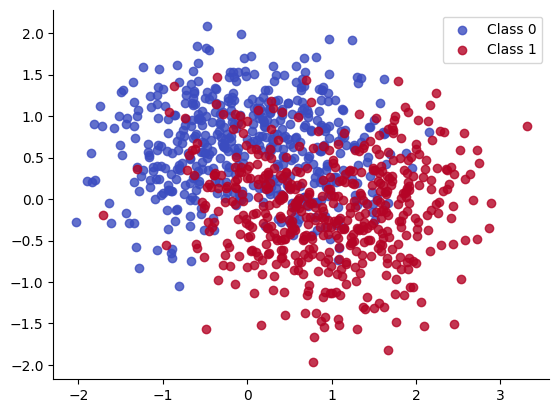

In [295]:
n_samples = 1000
grid = jnp.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T

Xs, Ys = make_moons(noise=0.5, n_samples=n_samples)
for i in range(2):
    plt.scatter(Xs[Ys == i, 0], Xs[Ys == i, 1], color=cmap(float(i)), label=f"Class {i}", alpha=.8)
plt.legend();

In [296]:
Xs_train = Xs[: n_samples // 2 ,:]
Xs_test = Xs[n_samples // 2 :,:]
Ys_train = Ys[: n_samples // 2]
Ys_test = Ys[n_samples // 2 :]

In [297]:
def inference_loop(rng_key, step_fn, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = step_fn(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [298]:
def get_predictions(model, samples, X, rng_key):
    vectorized_apply = jax.vmap(model.apply, in_axes=(0, None), out_axes=0)
    z = vectorized_apply(samples, X)
    predictions = tfd.Bernoulli(logits=z).sample(seed=rng_key)

    return predictions.squeeze(-1)

In [299]:
def get_mean_predictions(predictions, threshold=0.5):
    # compute mean prediction and confidence interval around median
    mean_prediction = jnp.mean(predictions, axis=0)
    return mean_prediction > threshold

In [300]:
def fit_and_eval(
    rng_key,
    model,
    logdensity_fn,
    X_train,
    Y_train,
    X_test,
    grid,
    n_groups=None,
    num_warmup=1000,
    num_samples=500,
):
    (
        init_key,
        warmup_key,
        inference_key,
        train_key,
        test_key,
        grid_key,
    ) = jax.random.split(rng_key, 6)

    if n_groups is None:
        initial_position = model.init(init_key, jnp.ones(X_train.shape[-1]))
    else:
        initial_position = model.init(init_key, jnp.ones(X_train.shape))

    # initialization
    logprob = partial(logdensity_fn, X=X_train, Y=Y_train, model=model)

    # warm up
    adapt = blackjax.window_adaptation(blackjax.nuts, logprob)
    (final_state, params), _ = adapt.run(warmup_key, initial_position, num_warmup)
    step_fn = blackjax.nuts(logprob, **params).step

    # inference
    states = inference_loop(inference_key, step_fn, final_state, num_samples)
    samples = states.position
    print(samples)

    # evaluation
    predictions = get_predictions(model, samples, X_train, train_key)
    Y_pred_train = get_mean_predictions(predictions)

    predictions = get_predictions(model, samples, X_test, test_key)
    Y_pred_test = get_mean_predictions(predictions)

    pred_grid = get_predictions(model, samples, grid, grid_key)

    return Y_pred_train, Y_pred_test, pred_grid

# MLP

In [301]:
# MLP params
hidden_layer_width = 5
n_hidden_layers = 2

class NN(nn.Module):
    n_hidden_layers: int
    layer_width: int

    @nn.compact
    def __call__(self, x):
        for i in range(self.n_hidden_layers):
            x = nn.Dense(features=self.layer_width)(x)
            x = nn.tanh(x)
        return nn.Dense(features=1)(x)


bnn = NN(n_hidden_layers, hidden_layer_width)

In [302]:
def logprior_fn(params):
    leaves, _ = jax.tree_util.tree_flatten(params)
    flat_params = jnp.concatenate([jnp.ravel(a) for a in leaves])
    return jnp.sum(tfd.Normal(0, 1).log_prob(flat_params))


def loglikelihood_fn(params, X, Y, model):
    logits = jnp.ravel(model.apply(params, X))
    return jnp.sum(tfd.Bernoulli(logits).log_prob(Y))


def logdensity_fn_of_bnn(params, X, Y, model):
    return logprior_fn(params) + loglikelihood_fn(params, X, Y, model)

In [303]:
rng_key, eval_key = jax.random.split(rng_key)


def fit_and_eval_single_mlp(key, X_train, Y_train, X_test):
    return fit_and_eval(
        key, bnn, logdensity_fn_of_bnn, X_train, Y_train, X_test, grid, n_groups=None
    )


Ys_pred_train, Ys_pred_test, ppc_grid_single = fit_and_eval_single_mlp(eval_key, Xs_train, Ys_train, Xs_test)

{'params': {'Dense_0': {'bias': Array([[-1.0819495 , -1.2457036 ,  1.7557474 ,  1.0505922 , -0.6269956 ],
       [-2.1455564 , -1.915119  ,  0.03679928,  0.0313986 , -0.78284246],
       [ 1.0988494 , -0.81928396, -0.35532346,  0.78009856,  1.1131259 ],
       ...,
       [-0.5252286 , -1.2249815 , -2.5094063 ,  0.07276295,  1.0790017 ],
       [-1.2007195 , -1.4045873 , -1.5274776 , -0.6606407 , -1.1602209 ],
       [-0.93183184, -0.39385885, -1.0658528 , -1.1368775 , -0.8542862 ]],      dtype=float32), 'kernel': Array([[[-0.5564411 ,  1.120967  , -1.1861689 , -1.8420755 ,
         -2.1103075 ],
        [ 0.60981727, -0.2913169 ,  0.99435747, -0.58858806,
          1.631293  ]],

       [[-0.42215925,  1.0752021 , -0.31368896, -1.3014549 ,
         -1.869581  ],
        [-0.39555353, -0.6262862 ,  0.205396  , -0.07766653,
          0.91414446]],

       [[ 1.5268364 ,  1.0452738 , -1.5412376 , -1.4670991 ,
         -0.56696975],
        [ 0.782286  , -0.6868547 ,  0.3201115 , -0.27283

In [304]:
print(f"Train accuracy = {100 * jnp.mean(Ys_pred_train == Ys_train):.2f}%")

Train accuracy = 83.00%


In [305]:
print(f"Test accuracy = {100 * jnp.mean(Ys_pred_test == Ys_test):.2f}%")

Test accuracy = 80.00%


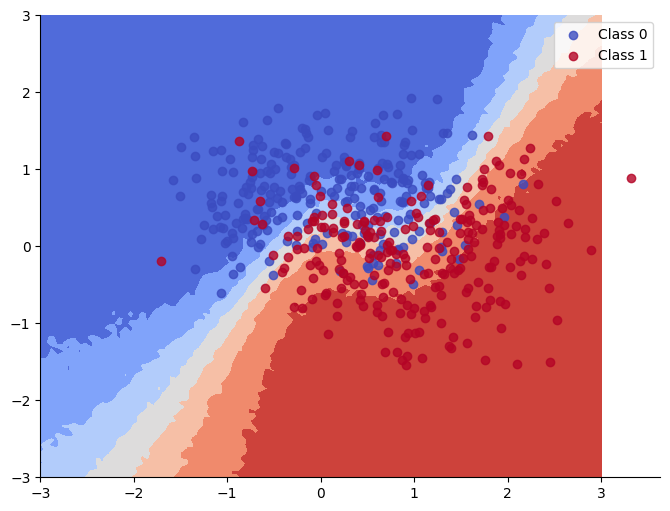

In [306]:
def plot_decision_surfaces_non_hierarchical():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.contourf(
        grid[:, 0].reshape(100, 100),
        grid[:, 1].reshape(100, 100),
        ppc_grid_single[...].mean(axis=0).reshape(100, 100),
        cmap=cmap,
    )
    for i in range(2):
        ax.scatter(
            Xs_train[Ys_train == i, 0], Xs_train[Ys_train == i, 1], 
            color=cmap(float(i)), label=f"Class {i}", alpha=.8)
    ax.legend()

plot_decision_surfaces_non_hierarchical()